In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Accumen challenge/AAPL.csv",
                   parse_dates=['Date'],
                   index_col=['Date'])

In [3]:
df['Close'].isna().sum()

0

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.850643,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.778926,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.790324,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.721930,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.756128,460734400


In [5]:
close_price = df['Close']

In [6]:
stock_price = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
stock_price.head()

,Price
Date,
2000-01-03,0.999442
2000-01-04,0.915179
2000-01-05,0.928571
2000-01-06,0.848214
2000-01-07,0.888393


Text(0.5, 1.0, 'AAPL')

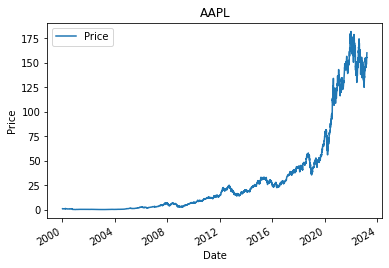

In [7]:
import matplotlib.pyplot as plt

stock_price.plot()
plt.ylabel("Price")
plt.title("AAPL")

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
timesteps = stock_price.index.to_numpy()
prices = scaler.fit_transform(np.array(stock_price).reshape(-1,1))

In [10]:
prices

array([[0.00420934],
       [0.00374579],
       [0.00381946],
       ...,
       [0.86697896],
       [0.87303033],
       [0.88029206]])

In [11]:
split_size = int(0.8 * len(stock_price))
# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(4675, 1169, 4675, 1169)

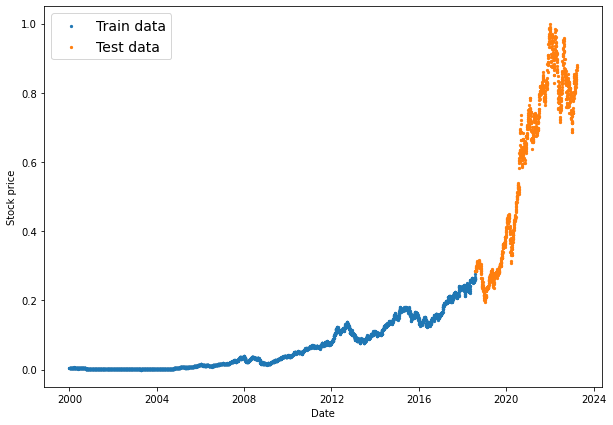

In [13]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(fontsize=14)
plt.show();

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [15]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7

In [16]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [17]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [18]:
import numpy as np
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(5837, 5837)

In [19]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [[0.00420934]
 [0.00374579]
 [0.00381946]
 [0.00337739]
 [0.00359843]
 [0.00351247]
 [0.00326688]] -> Label: [[0.00299366]]
Window: [[0.00374579]
 [0.00381946]
 [0.00337739]
 [0.00359843]
 [0.00351247]
 [0.00326688]
 [0.00299366]] -> Label: [[0.00346335]]
Window: [[0.00381946]
 [0.00337739]
 [0.00359843]
 [0.00351247]
 [0.00326688]
 [0.00299366]
 [0.00346335]] -> Label: [[0.00364447]]


In [20]:
time,time_labels = make_windows(timesteps,window_size=WINDOW_SIZE, horizon=HORIZON)
len(time),len(time_labels)

(5837, 5837)

In [21]:
for i in range(3):
  print(f"Window: {time[i]} -> Label: {time_labels[i]}")

Window: ['2000-01-03T00:00:00.000000000' '2000-01-04T00:00:00.000000000'
 '2000-01-05T00:00:00.000000000' '2000-01-06T00:00:00.000000000'
 '2000-01-07T00:00:00.000000000' '2000-01-10T00:00:00.000000000'
 '2000-01-11T00:00:00.000000000'] -> Label: ['2000-01-12T00:00:00.000000000']
Window: ['2000-01-04T00:00:00.000000000' '2000-01-05T00:00:00.000000000'
 '2000-01-06T00:00:00.000000000' '2000-01-07T00:00:00.000000000'
 '2000-01-10T00:00:00.000000000' '2000-01-11T00:00:00.000000000'
 '2000-01-12T00:00:00.000000000'] -> Label: ['2000-01-13T00:00:00.000000000']
Window: ['2000-01-05T00:00:00.000000000' '2000-01-06T00:00:00.000000000'
 '2000-01-07T00:00:00.000000000' '2000-01-10T00:00:00.000000000'
 '2000-01-11T00:00:00.000000000' '2000-01-12T00:00:00.000000000'
 '2000-01-13T00:00:00.000000000'] -> Label: ['2000-01-14T00:00:00.000000000']


In [22]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [23]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(4669, 1168, 4669, 1168)

In [24]:
time_train,time_test,time_train_labels,time_test_labels = make_train_test_splits(time,time_labels)
len(time_train), len(time_test), len(time_train_labels), len(time_test_labels)

(4669, 1168, 4669, 1168)

In [25]:
train_windows.shape , train_labels.shape

((4669, 7, 1), (4669, 1, 1))

In [26]:
train_labels = train_labels.reshape((4669))

In [27]:
train_labels

array([0.00299366, 0.00346335, 0.00364447, ..., 0.260421  , 0.27583836,
       0.28393901])

In [28]:
test_labels.shape, test_windows.shape

((1168, 1, 1), (1168, 7, 1))

In [29]:
test_labels = test_labels.reshape((1168))

In [30]:
test_labels.shape

(1168,)

In [31]:
train_windows =train_windows.reshape(train_windows.shape[0],train_windows.shape[1] , 1)
test_windows = test_windows.reshape(test_windows.shape[0],test_windows.shape[1] , 1)

In [32]:
train_windows.shape , test_windows.shape

((4669, 7, 1), (1168, 7, 1))

In [33]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(7,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 7, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(train_windows,train_labels,validation_data=(test_windows,test_labels),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
73/73 [==============================] - 8s 37ms/step - loss: 0.0012 - val_loss: 5.9736e-04
Epoch 2/100
73/73 [==============================] - 1s 19ms/step - loss: 1.0990e-05 - val_loss: 5.8926e-04
Epoch 3/100
73/73 [==============================] - 1s 16ms/step - loss: 9.5799e-06 - val_loss: 7.5556e-04
Epoch 4/100
73/73 [==============================] - 1s 16ms/step - loss: 9.5049e-06 - val_loss: 0.0014
Epoch 5/100
73/73 [==============================] - 1s 16ms/step - loss: 9.7376e-06 - val_loss: 0.0012
Epoch 6/100
73/73 [==============================] - 1s 16ms/step - loss: 9.4582e-06 - val_loss: 0.0023
Epoch 7/100
73/73 [==============================] - 1s 16ms/step - loss: 1.0108e-05 - val_loss: 0.0019
Epoch 8/100
73/73 [==============================] - 1s 16ms/step - loss: 1.0145e-05 - val_loss: 0.0022
Epoch 9/100
73/73 [==============================] - 1s 16ms/step - loss: 1.0397e-05 - val_loss: 0.0023
Epoch 10/100
73/73 [==============================] - 1s

In [36]:
test_predict=model.predict(test_windows)

37/37 [==============================] - 2s 8ms/step


In [37]:
test_predict

array([[0.27676538],
       [0.28359887],
       [0.28725213],
       ...,
       [0.85254264],
       [0.85387033],
       [0.85554385]], dtype=float32)

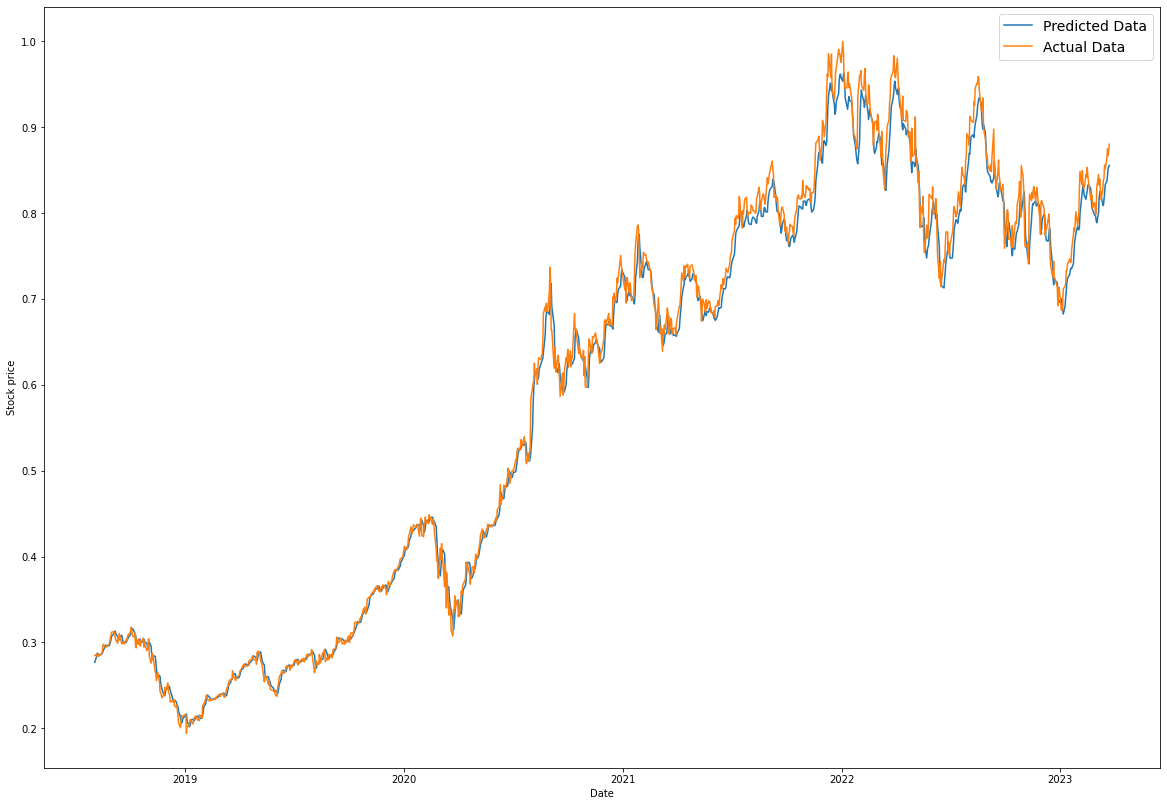

In [41]:
plt.figure(figsize=(20, 14))
plt.plot(time_test_labels,test_predict,label = "Predicted Data")
plt.plot(time_test_labels,test_labels,label = "Actual Data")
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(fontsize=14)
plt.show()

Similar Steps can be followed as followed in Tata Motors Stock prediction to generate BUY/SELL signals and calculating the indicators